<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/amazon_fashion/fashion_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install emoji library
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 20 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string

# store models
import pickle
from sklearn.pipeline import Pipeline

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load the fashion data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/fashion/02_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/fashion/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/fashion/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/fashion/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(530, 3)
 1.0    386
-1.0     98
 0.0     46
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This China Silk Black Balaclava is great for k...
1,1.0,2004,This item is very lightweight (as you'd expect...
2,1.0,2006,This item came in only 2 days and in perfect c...
3,1.0,2006,This ring was well worth the price. It has a l...
4,1.0,2006,"It was exactly as described. Beautiful ring, ..."


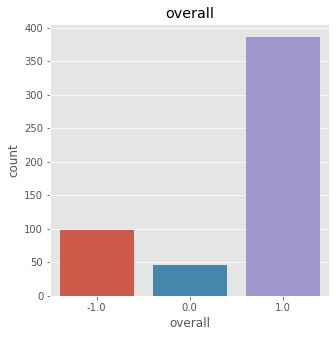

In [ ]:
# load data for 2002 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(16800, 3)
 1.0    12574
-1.0     2657
 0.0     1569
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2012,"I ordered a ladies cigarette case for my wife,..."
1,1.0,2010,Received the case in less than a week...was ve...
2,-1.0,2012,Don't buy this shirt unless you plan to spend ...
3,1.0,2012,"Nice shirt, Well made. good sizing. Nice color..."
4,1.0,2011,If you want a look that takes it back to the O...


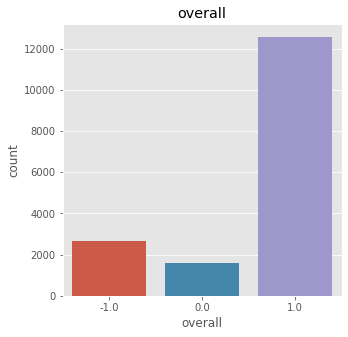

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(614812, 3)
 1.0    413534
-1.0    130175
 0.0     71103
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,Exactly what I needed.
1,-1.0,2014,"I agree with the other review, the opening is ..."
2,1.0,2014,Love these... I am going to order another pack...
3,-1.0,2014,too tiny an opening
4,0.0,2014,Okay


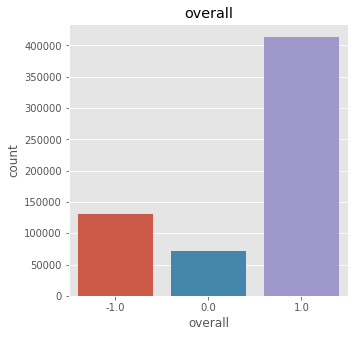

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(47246, 3)
 1.0    33622
-1.0     8865
 0.0     4759
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,Just what I needed for a party
1,1.0,2018,Son loves it. Decent quality.
2,1.0,2018,My son wanted to dress like August Pullman fro...
3,1.0,2018,awesome.
4,1.0,2018,My daughter loves this item. My high score is ...


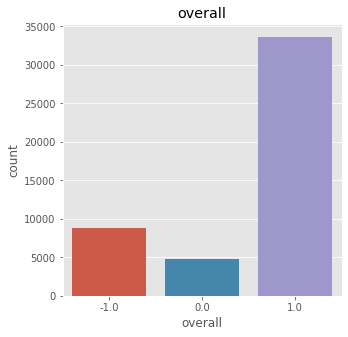

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

In [ ]:
def split_balance(df,counts):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # compute the index to split 80% for train 20% for test
  posind = int(counts[1]*0.8)
  neuind = int(counts[0]*0.8)
  negind = int(counts[-1]*0.8)

  # split to get train for each class
  pos_train = pos.iloc[:posind,:]
  neu_train = neu.iloc[:neuind,:]
  neg_train = neg.iloc[:negind,:]

  # split to get test for each class
  pos_test = pos.iloc[posind:,:]
  neu_test = neu.iloc[neuind:,:]
  neg_test = neg.iloc[negind:,:]

  # combine train dataset
  df_train = pd.concat([pos_train, neu_train, neg_train],sort=False).sample(frac=1.0)
  df_train_label = df_train.overall

  # combine test dataset
  df_test = pd.concat([pos_test, neu_test, neg_test],sort=False).sample(frac=1.0)
  df_test_label = df_test.overall

  return df_train,df_train_label,df_test,df_test_label

In [ ]:
# split train and test data for 1998 - 2006
df1_train,df1_train_label,df1_test,df1_test_label = split_balance(df1,counts1)

# get train and test text
df1_train_data = df1_train.reviewText
df1_test_data = df1_test.reviewText

In [ ]:
# split train and test data for 2007 - 2012
df2_train,df2_train_label,df2_test,df2_test_label = split_balance(df2,counts2)

# get train and test text
df2_train_data = df2_train.reviewText
df2_test_data = df2_test.reviewText

In [ ]:
# split train and test data for 2013 - 2017
df3_train,df3_train_label,df3_test,df3_test_label = split_balance(df3,counts3)

# get train and test text
df3_train_data = df3_train.reviewText
df3_test_data = df3_test.reviewText

In [ ]:
# split train and test data for 2018
df4_train,df4_train_label,df4_test,df4_test_label = split_balance(df4,counts4)

# get train and test text
df4_train_data = df4_train.reviewText
df4_test_data = df4_test.reviewText

In [ ]:
df1_test_data.shape

(108,)

## Text Preprocessing

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # convert tweet to lower case
  txt = txt.lower()
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  # remove whitespace
  txt = txt.strip()

  # tokenization with nltk
  data = word_tokenize(txt)
  # stemming with nltk
  porter = PorterStemmer()
  stem_data = [porter.stem(word) for word in data]
  return stem_data

## Text Representation

#### Learn on 2002-2006;Estimate on 2018

In [ ]:
# 2min
# TFIDF, unigrams and trigrams
tf_vect1 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
# fit on previous data
tf_vect1.fit_transform(df1.reviewText)

# transform testing and training datasets to vectors
df1_train_vect = tf_vect1.transform(df1_train_data)
df1_test_vect = tf_vect1.transform(df1_test_data)

# transform on 2018 test data
df4_test_vect = tf_vect1.transform(df4_test_data)

#### Learn on 2007-2012;Estimate on 2018

In [ ]:
# 3min
tf_vect2 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
tf_vect2.fit_transform(df2.reviewText)
df2_train_vect = tf_vect2.transform(df2_train_data)
df2_test_vect = tf_vect2.transform(df2_test_data)

# transform on 2018 test data
df4_test_vect2 = tf_vect2.transform(df4_test_data)

### Learn on 2013-2017;Estimate on 2018

In [ ]:
# 21min
tf_vect3 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
tf_vect3.fit_transform(df3.reviewText)
df3_train_vect = tf_vect3.transform(df3_train_data)
df3_test_vect = tf_vect3.transform(df3_test_data)

# transform on 2018 test data
df4_test_vect3 = tf_vect3.transform(df4_test_data)

## Classifiers

### Learn on 2002-2006;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc1 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc1.fit(df1_train_vect, df1_train_label)
ysvm_pred = svc1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ysvm_pred, average='micro') * 100))

Accuracy: 72.22%

F1 Score: 72.22


In [ ]:
# estimate on 2018 data
ysvm_pred_18 = svc1.predict(df4_test_vect)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred_18, average='micro') * 100))

Accuracy: 71.70%

F1 Score: 71.70


#### Logistic Regression

In [ ]:
lr1=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr1.fit(df1_train_vect, df1_train_label)
ylog_pred = lr1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ylog_pred, average='micro') * 100))

Accuracy: 72.22%

F1 Score: 72.22


In [ ]:
ylog_pred_18 = lr1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred_18, average='micro') * 100))

Accuracy: 71.48%

F1 Score: 71.48


#### Naive Bayes

In [ ]:
nb1 = MultinomialNB(alpha=0.1,fit_prior=True)

nb1.fit(df1_train_vect, df1_train_label)
ynb_pred = nb1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ynb_pred, average='micro') * 100))

Accuracy: 75.00%

F1 Score: 75.00


In [ ]:
ynb_pred_18 = nb1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred_18, average='micro') * 100))

Accuracy: 71.43%

F1 Score: 71.43


#### Random Forest

In [ ]:
rf1= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)

rf1.fit(df1_train_vect, df1_train_label)
yrf_pred = rf1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, yrf_pred, average='micro') * 100))

Accuracy: 72.22%

F1 Score: 72.22


In [ ]:
yrf_pred_18 = rf1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred_18, average='micro') * 100))

Accuracy: 71.22%

F1 Score: 71.22


### Learn on 2007-2012;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc2 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc2.fit(df2_train_vect, df2_train_label)
ysvm_pred2 = svc2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ysvm_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ysvm_pred2, average='micro') * 100))

Accuracy: 84.02%

F1 Score: 84.02


In [ ]:
# estimate on 2018 data
ysvm_pred2_18 = svc2.predict(df4_test_vect2)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred2_18, average='micro') * 100))

Accuracy: 82.41%

F1 Score: 82.41


#### Logistic Regression

In [ ]:
lr2=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr2.fit(df2_train_vect, df2_train_label)
ylog_pred2 = lr2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ylog_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ylog_pred2, average='micro') * 100))

Accuracy: 83.58%

F1 Score: 83.58


In [ ]:
ylog_pred2_18 = lr2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred2_18, average='micro') * 100))

Accuracy: 82.19%

F1 Score: 82.19


#### Naive Bayes

In [ ]:
nb2 = MultinomialNB(alpha=0.1,fit_prior=True)

nb2.fit(df2_train_vect, df2_train_label)
ynb_pred2 = nb2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ynb_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ynb_pred2, average='micro') * 100))

Accuracy: 79.29%

F1 Score: 79.29


In [ ]:
ynb_pred2_18 = nb2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred2_18, average='micro') * 100))

Accuracy: 73.42%

F1 Score: 73.42


#### Random Forest

In [ ]:
rf2= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)

rf2.fit(df2_train_vect, df2_train_label)
yrf_pred2 = rf2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, yrf_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, yrf_pred2, average='micro') * 100))

Accuracy: 76.52%

F1 Score: 76.52


In [ ]:
yrf_pred2_18 = rf2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred2_18, average='micro') * 100))

Accuracy: 72.53%

F1 Score: 72.53


### Learn on 2013-2017;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc3 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc3.fit(df3_train_vect, df3_train_label)
ysvm_pred3 = svc3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ysvm_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ysvm_pred3, average='micro') * 100))

Accuracy: 84.85%

F1 Score: 84.85


In [ ]:
# estimate on 2018 data
ysvm_pred3_18 = svc3.predict(df4_test_vect3)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred3_18, average='micro') * 100))

Accuracy: 86.37%

F1 Score: 86.37


#### Logistic Regression

In [ ]:
lr3=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr3.fit(df3_train_vect, df3_train_label)
ylog_pred3 = lr3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ylog_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ylog_pred3, average='micro') * 100))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 84.64%

F1 Score: 84.64


In [ ]:
ylog_pred3_18 = lr3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred3_18, average='micro') * 100))

Accuracy: 86.11%

F1 Score: 86.11


#### Naive Bayes

In [ ]:
nb3 = MultinomialNB(alpha=0.1,fit_prior=True)

nb3.fit(df3_train_vect, df3_train_label)
ynb_pred3 = nb3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ynb_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ynb_pred3, average='micro') * 100))

Accuracy: 82.96%

F1 Score: 82.96


In [ ]:
ynb_pred3_18 = nb3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred3_18, average='micro') * 100))

Accuracy: 83.04%

F1 Score: 83.04


#### Random Forest

In [ ]:
# estimated 5hrs
rf3= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)
rf3.fit(df3_train_vect, df3_train_label)
yrf_pred3 = rf3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, yrf_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, yrf_pred3, average='micro') * 100))

In [ ]:
yrf_pred3_18 = rf3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred3_18, average='micro') * 100))

## store models

In [ ]:
def store_model(i,vect,svm,lr,nb,rf):
  pipe1 = Pipeline([
    ('tfidf', vect),
    ('svm', svm),
    ])
  pipe2 = Pipeline([
    ('tfidf', vect),
    ('lr', lr),
    ])
  pipe3 = Pipeline([
    ('tfidf', vect),
    ('nb', nb),
    ])
  pipe4 = Pipeline([
    ('tfidf', vect),
    ('rf', rf),
    ])
  if i == 1:
    dir = '02_06'
  elif i == 2:
    dir = '07_12'
  else:
    dir = '13_17'
  filename1 = './drive/MyDrive/Colab Notebooks/CL/fashion/'+dir+'/svm.pickle'
  filename2 = './drive/MyDrive/Colab Notebooks/CL/fashion/'+dir+'/lr.pickle'
  filename3 = './drive/MyDrive/Colab Notebooks/CL/fashion/'+dir+'/nb.pickle'
  filename4 = './drive/MyDrive/Colab Notebooks/CL/fashion/'+dir+'/rf.pickle'
  pickle.dump(pipe1, open(filename1, 'wb'))
  pickle.dump(pipe2, open(filename2, 'wb'))
  pickle.dump(pipe3, open(filename3, 'wb'))
  pickle.dump(pipe4, open(filename4, 'wb'))

In [ ]:
store_model(1,tf_vect1,svc1,lr1,nb1,rf1)

In [ ]:
store_model(2,tf_vect2,svc2,lr2,nb2,rf2)

In [ ]:
store_model(3,tf_vect3,svc3,lr3,nb3,rf3)